In [6]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA

import matplotlib.pyplot as plt


from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [7]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "encoder" # encoder or decoder
task = "rte"

## Prompts

In [8]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}.csv")
display(df)

,name,template,category,shuffle
0,null_pattern,{premise} {hypothesis},neutral,False
1,null_pattern_reversed,{hypothesis} {premise},neutral,False
2,gpt_3_yes_no,{premise} Question: {hypothesis} Yes or No?,instructive,False
3,gpt_3_yes_no_shuffled,{premise} Question: {hypothesis} Yes or No?,instructive,True
4,gpt_3_true_false,{premise} Question: {hypothesis} True or False?,instructive,False
5,gpt_3_true_false_shuffled,{premise} Question: {hypothesis} True or False?,instructive,True
6,start_with_the,"{premise} Does the paragraph start with ""the""?...",misleading,False
7,mnli_crowdsource,{premise} Using only the above description and...,instructive,False
8,based_on_previous_passage,{premise} Based on the previous passage; is it...,instructive,False
9,infer,"Suppose {premise} Can we infer that ""{hypothes...",instructive,False


## Comput CKA

In [9]:
# specify which patterns to use
use_pattern = [
    "null_pattern",
    "null_pattern_reversed",
    "gpt_3_yes_no",
    "gpt_3_yes_no_shuffled",
    "gpt_3_true_false",
    "gpt_3_true_false_shuffled",
    "start_with_the",
    "mnli_crowdsource",
    "based_on_previous_passage",
    "infer",
    "follow",
    "imply",
    "guaranteed",
    "justified", 
    "must_be_true",
    "should_assume"
]

In [10]:
representations = {}

# for layer in range(0, 1):
# for layer in range(0, 5):
for layer in range(0, 25):
# for layer in range(24, 25):
    
    file_names, prompt_names = [], []

    layer_key = f"{module}-{layer}"
    if layer_key not in representations:
        representations[layer_key] = {}
    
    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_name = f"rte/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5"
            file_names.append(file_name)
            prompt_names.append(row['name'])
            if file_name not in representations[layer_key]:
                # load hidden representations from hdf5 file
                representations[layer_key][file_name] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
    
    

Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5618.91it/s]


In [11]:
representations["encoder-0"].keys()

dict_keys(['rte/bigscience-T0_3B/encoder/null_pattern/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/null_pattern_reversed/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/gpt_3_yes_no/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/gpt_3_yes_no_shuffled/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/gpt_3_true_false/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/gpt_3_true_false_shuffled/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/start_with_the/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/mnli_crowdsource/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/based_on_previous_passage/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/infer/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/follow/hidden_represenations_layer0_avg.hdf5', 'rte/bigscience-T0_3B/encoder/imply

In [12]:
len(representations["encoder-0"].keys())

16

In [13]:
# Compute pairwise CKA for every layer
np_cka = CKA()

cka_scores_layers = {}
for layer in list(representations.keys())[:]:
    cka_scores = []
    for pattern1 in representations[layer].keys():
        cka_scores_pattern1 = []
        for pattern2 in representations[layer].keys():
            # print(representations[layer][pattern1].shape, representations[layer][pattern2].shape)
            cka_score = np_cka.linear_CKA(representations[layer][pattern1], representations[layer][pattern2])
            cka_scores_pattern1.append(cka_score)
        cka_scores.append(cka_scores_pattern1)
    cka_scores = np.asarray(cka_scores)
    cka_scores_layers[layer] = cka_scores
    # print(cka_scores.shape)


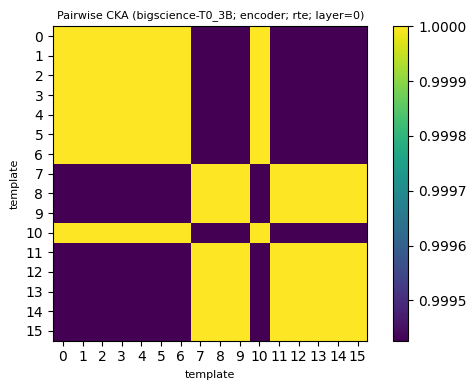

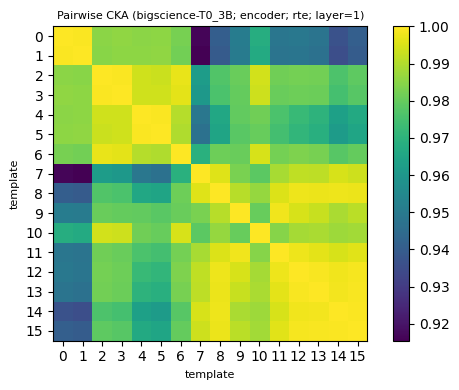

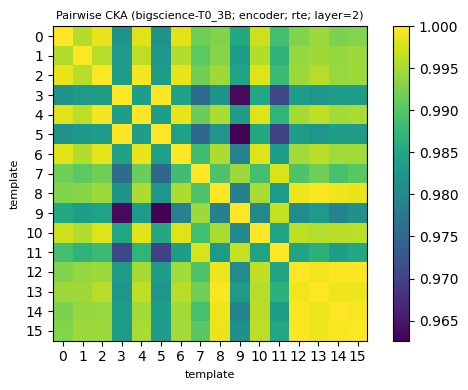

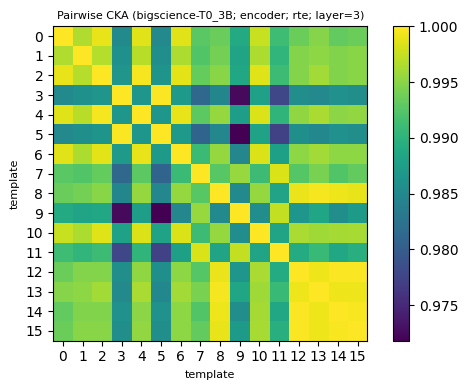

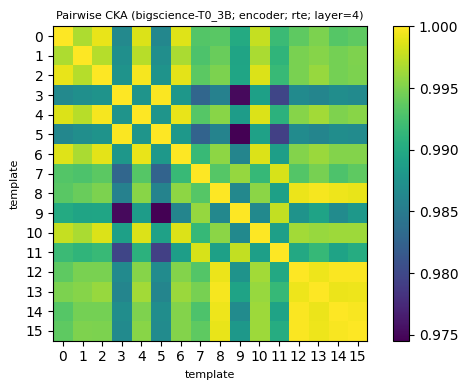

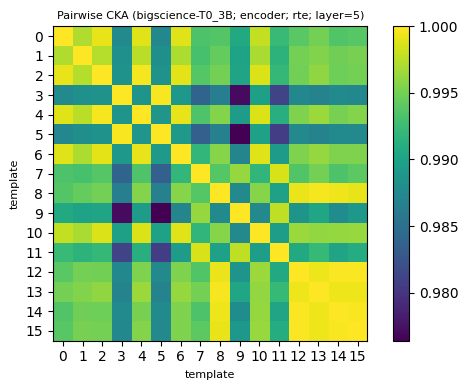

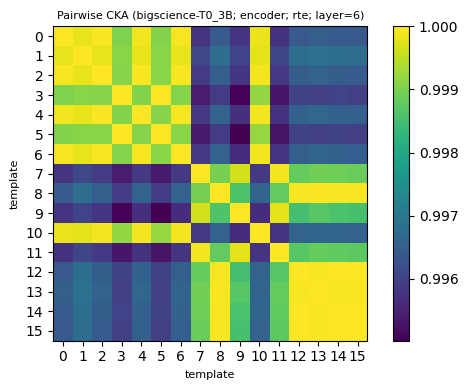

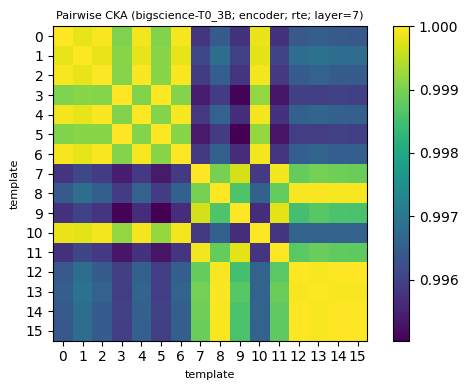

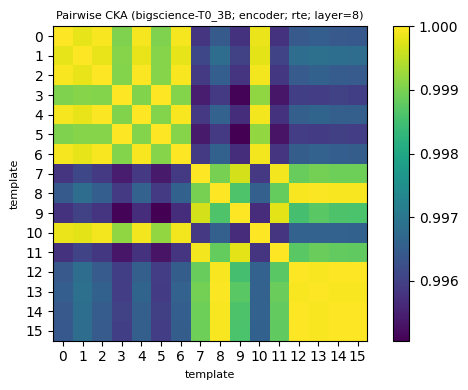

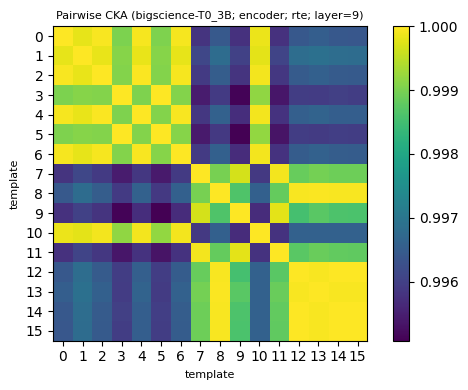

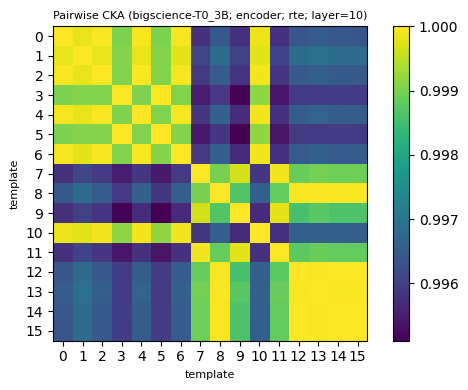

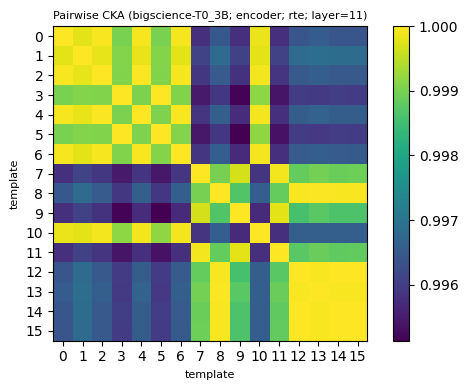

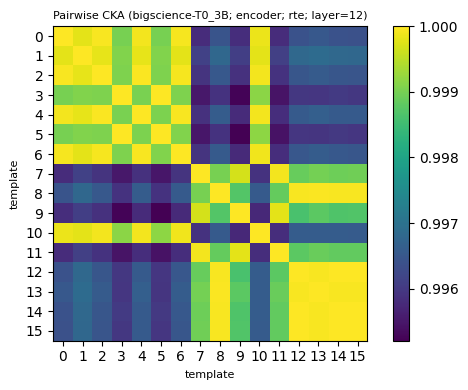

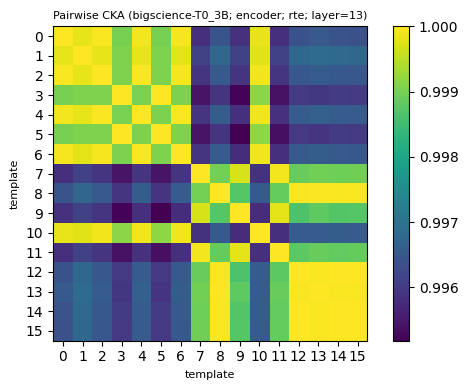

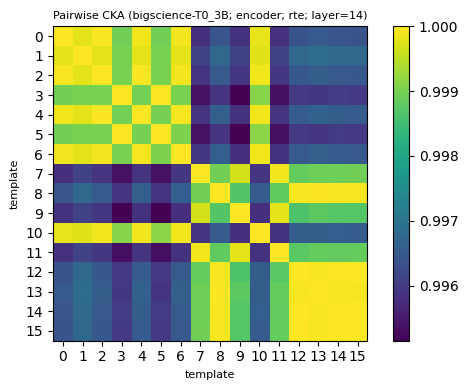

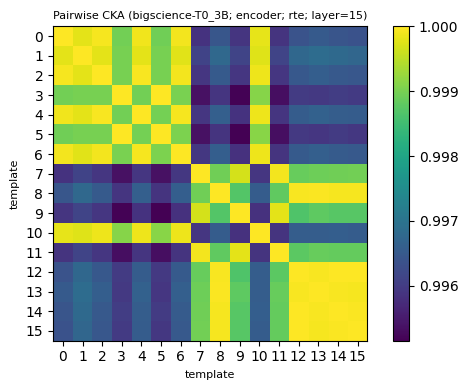

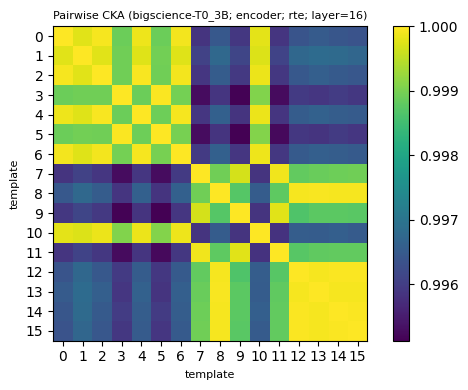

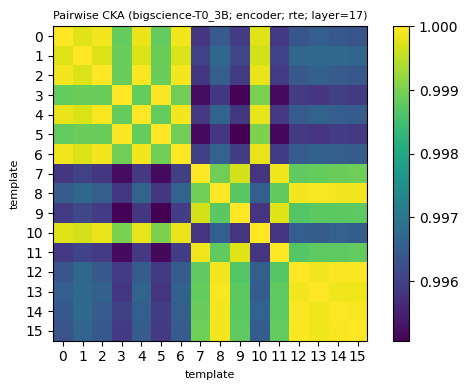

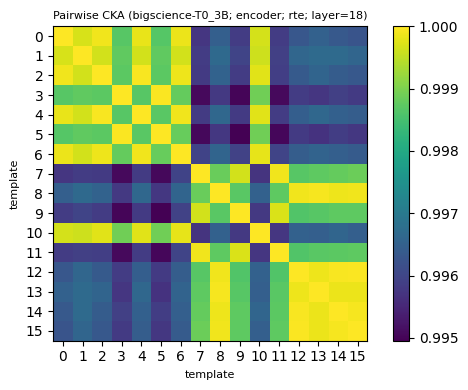

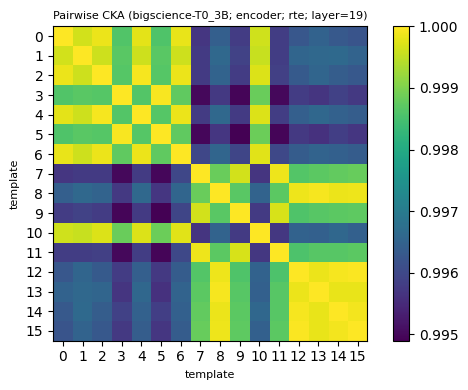

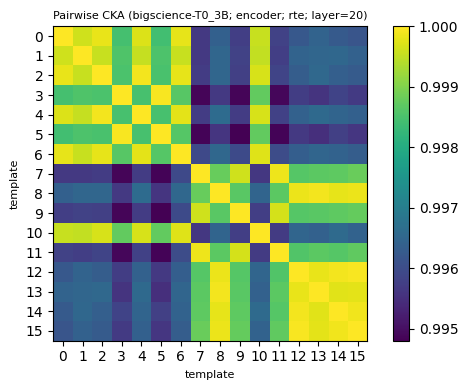

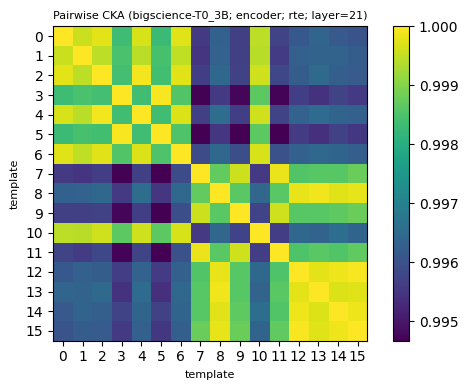

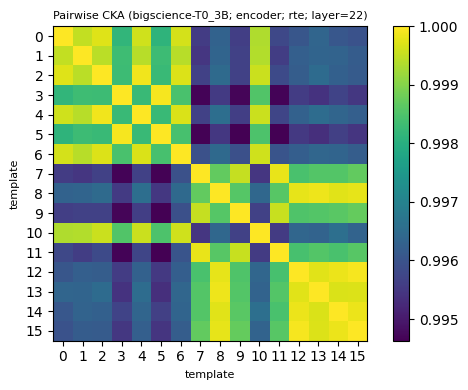

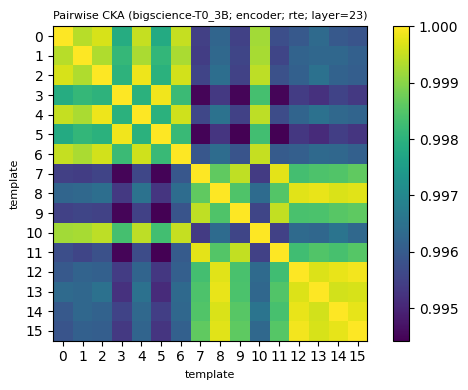

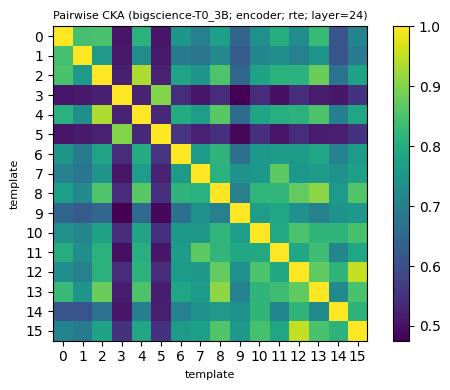

In [14]:
for layer_key in cka_scores_layers.keys():
    values = cka_scores_layers[layer_key]
    layer = layer_key.split('-')[-1]

    fig, axes = plt.subplots(1, 1, figsize=(5.5,4), dpi=100)

    im = axes.imshow(values, cmap='viridis', vmax=1.0)
    # Create colorbar
    cbar = axes.figure.colorbar(im, ax=axes)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.close();


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


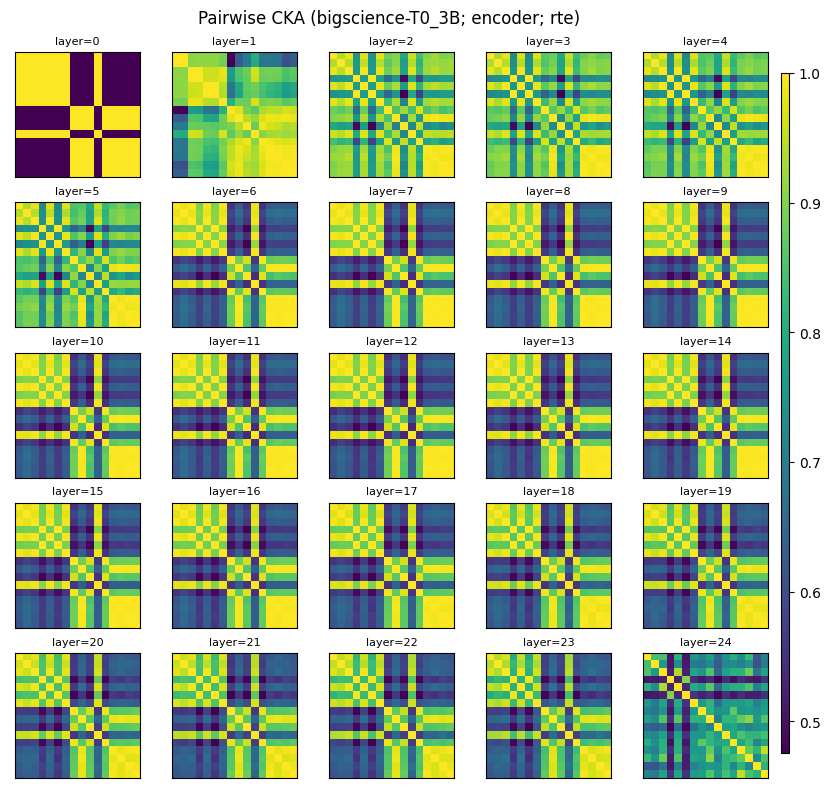

In [30]:
plt.figure(figsize=(8, 8), dpi=100)

for l, layer_key in enumerate(cka_scores_layers.keys()):
    values = cka_scores_layers[layer_key]
    layer = layer_key.split('-')[-1]

    plt.subplot(5, 5, l+1)
    axes = plt.gca()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    im = axes.imshow(values, cmap='viridis', vmax=1.0)
    # Create colorbar
    # cbar = axes.figure.colorbar(im, ax=axes)
    # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
    axes.set_title(f"layer={layer}", fontsize=8)

# add colorbar
fig = plt.gcf()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.05, 0.01, 0.85])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle(f"Pairwise CKA ({model}; {module}; {task})")
plt.tight_layout()
plt.show()
plt.close();